# Assignment 1 - Elements of Projective Geometry
**Date:** 2024-11-04

**Author:** Johannes Holmgren

In [22]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from data.compEx1 import x2D, x3D

In [23]:
# Function to plot coordinates in 2D
def plot_points_2D(points: np.ndarray) -> None:
    ''' Plot points in 2D space

    Plots all 'n' points (2 x n) using matplotlib.

    Parameters
    ----------
    points: np.ndarray
        A 2 x n matrix representing 'n' points
    
    '''
    fig, ax = plt.subplots()
    ax.scatter(points[0,:], points[1,:])
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

# Function to plot coordinates in 3D
def plot_points_3D(points: np.ndarray) -> None:
    ''' Plot points in 3D space

    Plots all 'n' points (3 x n) using matplotlib.

    Parameters
    ----------
    points: np.ndarray
        A 3 x n matrix representing 'n' points
    
    '''
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(points[0,:], points[1,:], points[2,:])
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

In [24]:
# Computer Exercise 1
def pflat(matrix: np.ndarray) -> np.ndarray:
    ''' Normalize 'n' points of dimension 'm' 

    Normalized by dividing by the last item for each point.
    It is assumed that the last coordinate is non-zero. 

    Parameters
    ----------
    matrix: np.ndarray
        A m x n matrix 
    
    Returns
    -------
    np.ndarray
        A normalized matrix of size m x n where the last element is 1
    '''
    return matrix / matrix[-1]


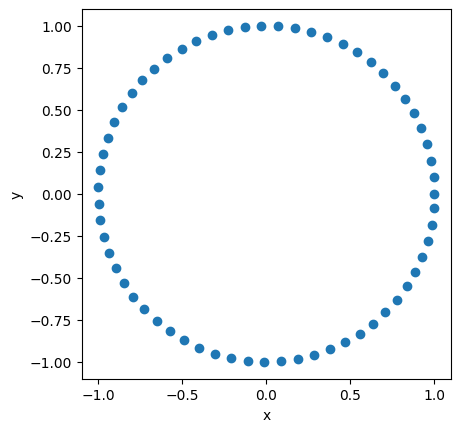

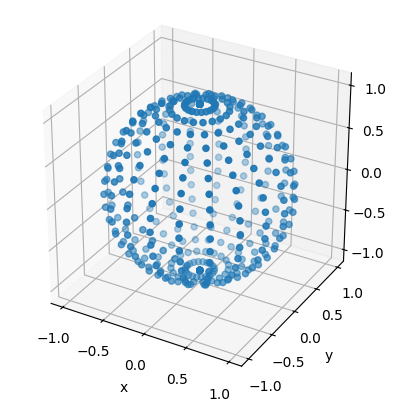

In [25]:
# Run code for data x2D and x3D
res2D = pflat(x2D)
res3D = pflat(x3D)
plot_points_2D(res2D)
plot_points_3D(res3D)